# Digit Recognizer ([following this guide](https://www.kaggle.com/kakauandme/tensorflow-deep-nn))

## Libraries and settings

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# Settings
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 2500
DROPOUT = 0.5
BATCH_SIZE = 50
VALIDATION_SIZE = 2500
IMAGE_TO_DISPLAY = 10

### Data Preparation

In [2]:
# Read training data
data = pd.read_csv('./train.csv')
print('data({0[0]},{0[1]})'.format(data.shape))
print(data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

Images are horizontally defined, that is, each row is a set of pixel which describes an image

In [3]:
images = data.iloc[:, 1:].values
images = images.astype(np.float)

# Convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


For this particular dataset, images are 784 pixels, which mean they are 28px * 28px

In [4]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# Images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width, image_height))

image_size => 784
image_width => 28
image_height => 28


Let's create a utility method to display an image given the file structure described above:

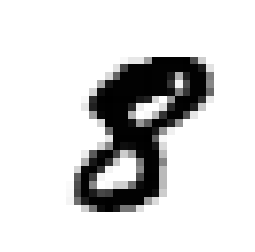

In [5]:
# Utility method to display an image
def display(img):
    # (784) => (28, 28)
    one_image = img.reshape(image_width, image_height)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# Test method    
display(images[IMAGE_TO_DISPLAY])

Each image has a label, which corresponds to the actual number the image represents

In [6]:
labels_flat = data.iloc[:,0].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


There are 10 different labels for digits (from 0 to 9)

In [7]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


For most classification problems "one-hot vectors" are used. A one-hot vector is a vector that contains a single element equal to 1 and the rest of the elements equal to 0. In this case, the nth digit is represented as a zero vector with 1 in the nth position.

In [8]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


Split dataset into training and validation

In [9]:
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(39500,784)
validation_images(2500,784)


### TensorFlow graph

TensorFlow does its heavy lifting outside Python. Therefore, instead of running every single operation independently, TensorFlow allows users to build a whole graph of interacting operations and then runs the workflow in a separate process at once.

In [10]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

A convolution layer is used to get the features of the data. In the case of digit recognition - a shape of each digit. It uses learnable kernels/filters each of which corresponds to one particular shape pattern. The number of the filter can differ for other problems.

In [11]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Pooling is used for downsampling of the data. 2x2 max-pooling splits the image into square 2-pixel blocks and only keeps maximum value for each of those blocks.

In [12]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

The output of one neural network can be used as input for another. This sequential approach can create very sophisticated NN with multiple layers. They are also called Deep Neural Networks.

We'll use two convolution layers with pooling in between them, then densely connected layer followed by dropout and lastly readout layer.

In [13]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

The first layer is a convolution, followed by max pooling. The convolution computes 32 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels (1 means that images are grayscale), and the last is the number of output channels. There is also a bias vector with a component for each output channel.

In [16]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

The second layer has 64 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 32, 64]. The first two dimensions are the patch size, the next is the number of input channels (32 channels correspond to 32 featured that we got from previous convolutional layer), and the last is the number of output channels. There is also a bias vector with a component for each output channel.

In [17]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))
layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

Now that the image size is reduced to 7x7, we add a fully-connected layer with 1024 neurones to allow processing on the entire image (each of the neurons of the fully connected layer is connected to all the activations/outpus of the previous layer).

In [18]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

To prevent overfitting, we apply dropout before the readout layer. Dropout removes some nodes from the network at each training stage. Each of the nodes is either kept in the network with probability keep_prob or dropped with probability 1 - keep_prob. After the training stage is over the nodes are returned to the NN with their original weights.

In [19]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Softmax layer, the same one if we use just a simple softmax regression.

In [20]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
#print (y.get_shape()) # => (40000, 10)

To evaluate network performance we use cross-entropy and to minimise it ADAM optimiser is used.

In [21]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

To predict values from test data, highest probability is picked from "one-hot vector" indicating that chances of an image being one of the digits are highest.

In [23]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

### Train, validate and predict

Ideally, we should use all data for every step of the training, but that's expensive. So, instead, we use small "batches" of random data.
This method is called stochastic training. It is cheaper, faster and gives much of the same result.

In [24]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

Now when all operations for every variable are defined in TensorFlow graph all computations will be performed outside Python environment.

In [26]:
# start TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

In [27]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.14 / 0.12 for step 0
training_accuracy / validation_accuracy => 0.08 / 0.14 for step 1
training_accuracy / validation_accuracy => 0.24 / 0.18 for step 2
training_accuracy / validation_accuracy => 0.14 / 0.18 for step 3
training_accuracy / validation_accuracy => 0.16 / 0.18 for step 4
training_accuracy / validation_accuracy => 0.12 / 0.24 for step 5
training_accuracy / validation_accuracy => 0.26 / 0.22 for step 6
training_accuracy / validation_accuracy => 0.26 / 0.24 for step 7
training_accuracy / validation_accuracy => 0.42 / 0.28 for step 8
training_accuracy / validation_accuracy => 0.14 / 0.24 for step 9
training_accuracy / validation_accuracy => 0.22 / 0.20 for step 10
training_accuracy / validation_accuracy => 0.40 / 0.56 for step 20
training_accuracy / validation_accuracy => 0.54 / 0.68 for step 30
training_accuracy / validation_accuracy => 0.72 / 0.76 for step 40
training_accuracy / validation_accuracy => 0.66 / 0.86 for step 50
train

Check accuracy on data that wasn't used in training.

validation_accuracy => 0.9840


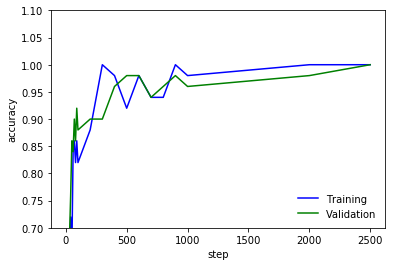

In [29]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

Read test data from `test.csv` and predict labels for provided images.

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0


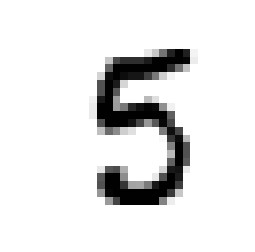

In [31]:
# read test data from CSV file 
test_images = pd.read_csv('./test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)
print('test_images({0[0]},{0[1]})'.format(test_images.shape))

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})

print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt('submission.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

In [33]:
sess.close()